# Offline Training in Two Networks

This notebook explores the EPIROB data in a two-step learning framework.

**The single-step, feedforward inverse and forward model**

This network takes sensor readings and the motor action made in that state, and outputs the next sensory state (a la "prediction"), and the *same* motor action. This model is designed to learn the effects of motor actions on the sensors, and to be able to take a hidden-layer representation and get the motor action back out (a motor decoder).

<pre>
+---------------------+  +------------+
|      sensor_t1      |  |  motor_t0  |
+---------------------+  +------------+
               ^           ^
         +---------------------+
         |       hidden_t0     |
         +---------------------+
               ^           ^
+---------------------+  +------------+
|      sensor_t0      |  |  motor_t0  |
+---------------------+  +------------+
</pre>


**The hidden-space-only sequence network.**

This network is also a feedforward network, learning to take hidden representations from the single-step network plus a hidden-layer representation of a goal, and give the next hidden layer representation. This network operates only in hidden space.

<pre>
           +---------------------+  
           |      hidden_t1      |  
           +---------------------+  
                      ^
               +--------------+
               |   hidden2    |
               +--------------+
                 ^           ^
+---------------------+  +---------------------+ 
|      hidden_t0      |  |      hidden_goal    | 
+---------------------+  +---------------------+ 
</pre>


# Training

In [1]:
import theano.tensor as T
import numpy as np
import sys
sys.path.append("..")

In [2]:
from discover import *

Using TensorFlow backend.


We import the discover program and load the experiment we are interested in:

In [3]:
FLAGS.directory = "../results" # Where to save/restore files
FLAGS.mode = 'test' # Should be 'wander' or 'test'
FLAGS.num_steps = 5000 # Number of steps to wander and learn
FLAGS.num_hiddens = 10 # Number of hidden units in model

In [4]:
gd = GoalDiscovery()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
g_in (InputLayer)                (None, 10)            0                                            
____________________________________________________________________________________________________
s_in (InputLayer)                (None, 19)            0                                            
____________________________________________________________________________________________________
m_in (InputLayer)                (None, 2)             0                                            
____________________________________________________________________________________________________
c_in (InputLayer)                (None, 10)            0                                            
___________________________________________________________________________________________

../discover.py:78: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  x = merge([g_in, s_in, m_in, c_in], mode='concat')
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
../discover.py:83: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  self.model = Model(input=[g_in, s_in, m_in, c_in], output=[g_out, s_out, m_out])
../discover.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  output=[self.model.get_layer('h').output])


In [5]:
gd.restore_model()


Restoring weights


Restoring goals


Restoring history



In [6]:
log = gd.read_log()

Rendering simulator images...


# Verification

First, we go through the data, making sure that we can replicate the goals, and senses:

In [7]:
def verify():
    for step in log["goals"]: # for each step goal created
        input_g = gd.history[step + 1]['sensors'][0]
        pose = log["poses"][step + 1]
        gd.robot.setPose(*pose)
        gd.robot.stall = log["stalls"][step + 1]
        sensors = gd.read_sensors()[0]
        if list(input_g) != list(sensors):
            print("goal wrong!", input_g, sensors)
        pose = log["poses"][step - gd.recall_steps]
        gd.robot.setPose(*pose)
        gd.robot.stall = log["stalls"][step - gd.recall_steps]
        sensors = gd.read_sensors()[0]
        input_s = gd.history[step - gd.recall_steps]['sensors'][0]
        if list(input_s) != list(sensors):
            print("initial sense wrong!")
            print(input_s)
            print(sensors)
        for j in range(-gd.recall_steps, 1, 1):
            input_s = gd.history[step + j + 1]['sensors'][0]
            target_m = gd.history[step + j]['motors'][0]
            # make move
            t, r = target_m
            gd.robot.move(t, r)
            gd.sim.step()
            new_pose = gd.robot.getPose()
            if new_pose != gd.history[step + j + 1]['pose']:
                print("step %d pose wrong!" % j)
                print(new_pose)
                print(gd.history[step + j + 1]['pose'])
            sensors = gd.read_sensors()[0]
            if list(input_s) != list(sensors):
                print("step %d wrong!" % j, (t, r))
                print(input_s)
                print(sensors)
        if list(input_s) != list(input_g):
            print("final goal wrong!")
            print(input_s)
            print(input_g)

In [8]:
verify()

Everything checks out.

# The Single-Step Forward/Inverse Model

Because this is a feedforward model, we can build a dataset and train in a standard input/target based manner.
The inputs are [sensor_t0 + motor_t0] and the targets are [sensor_t1 + motor_t0]. 

Note that because we use the sigmoid activation function, we convert the inputs/targets to 0/1.

In [9]:
from conx import Network

The step-wise model is straightforward, except for an initial sensor_t0 + motor-noop -> sensor_t0 step. That is a no-motion motor action that gives the same sensor readings (an identity function, of sorts). That we be explained more fully in the sequence model.

In [10]:
goalset = [10, 29, 33, 39, 40, 59, 68]

In [11]:
def build_stepwise_dataset(*goals):
    """
    Given sensor[t0] + motor[t0] -> sensor[t1] + motor[t0]
    """
    if len(goals) == 0:
        goals = range(len(log["goals"]))
    data = []
    for step in [log["goals"][goal] for goal in goals]: # for each step goal created
        # add the motor no-op
        sensor_t0 = gd.history[step - gd.recall_steps]['sensors'][0]
        motor = np.array([0.0, 0.0])
        # identity, noop, don't move
        data.append([np.concatenate([sensor_t0, (motor + 1)/2.0 ]), 
                     np.concatenate([sensor_t0, (motor + 1)/2.0])])
        for j in range(-gd.recall_steps, 2, 1):
            sensor_t0 = gd.history[step + j]['sensors'][0]
            motor = gd.history[step + j]['motors'][0]
            sensor_t1 = gd.history[step + j + 1]['sensors'][0]
            data.append([np.concatenate([sensor_t0, (motor + 1)/2.0 ]), 
                         np.concatenate([sensor_t1, (motor + 1)/2.0])])
    return data

We define the single-step model:

In [12]:
motor_size = 2
sensor_size = 19
hidden_size = 25
stepwise = Network(sensor_size + motor_size, hidden_size, sensor_size + motor_size, 
                    epsilon=0.1, momentum=0.1)

In [13]:
stepwise_dataset = build_stepwise_dataset(*goalset)
stepwise.set_inputs(stepwise_dataset)

In [14]:
len(stepwise_dataset)

91

In [15]:
stepwise.train(report_rate=10)

--------------------------------------------------
Training for max trails: 5000 ...
Epoch: 0 TSS error: 413.565559579 %correct: 0.0
Epoch: 10 TSS error: 29.3503226186 %correct: 0.0
Epoch: 20 TSS error: 21.6866630608 %correct: 0.0
Epoch: 30 TSS error: 18.5267451728 %correct: 6.593406593406594
Epoch: 40 TSS error: 16.0098766388 %correct: 8.791208791208792
Epoch: 50 TSS error: 14.4722500214 %correct: 10.989010989010989
Epoch: 60 TSS error: 13.713689066 %correct: 16.483516483516482
Epoch: 70 TSS error: 13.1156008968 %correct: 15.384615384615385
Epoch: 80 TSS error: 12.5149876758 %correct: 17.582417582417584
Epoch: 90 TSS error: 12.2126466742 %correct: 31.868131868131865
Epoch: 100 TSS error: 11.9480452878 %correct: 16.483516483516482
Epoch: 110 TSS error: 11.0609879529 %correct: 30.76923076923077
Epoch: 120 TSS error: 10.6897760085 %correct: 28.57142857142857
Epoch: 130 TSS error: 10.4051723535 %correct: 39.56043956043956
Epoch: 140 TSS error: 9.77134052754 %correct: 36.26373626373626
Epo

Epoch: 1290 TSS error: 0.981337097577 %correct: 90.10989010989012
Epoch: 1300 TSS error: 0.91961073013 %correct: 92.3076923076923
Epoch: 1310 TSS error: 0.916094677024 %correct: 93.4065934065934
Epoch: 1320 TSS error: 0.908816628642 %correct: 90.10989010989012
Epoch: 1330 TSS error: 0.865271297418 %correct: 92.3076923076923
Epoch: 1340 TSS error: 0.857828555992 %correct: 89.01098901098901
Epoch: 1350 TSS error: 0.88190639633 %correct: 90.10989010989012
Epoch: 1360 TSS error: 0.883177018059 %correct: 91.20879120879121
Epoch: 1370 TSS error: 0.884480134942 %correct: 90.10989010989012
Epoch: 1380 TSS error: 0.88501837862 %correct: 93.4065934065934
Epoch: 1390 TSS error: 0.883237160804 %correct: 91.20879120879121
Epoch: 1400 TSS error: 0.878688143824 %correct: 92.3076923076923
Epoch: 1410 TSS error: 0.87713982561 %correct: 92.3076923076923
Epoch: 1420 TSS error: 0.823953848241 %correct: 91.20879120879121
Epoch: 1430 TSS error: 0.850652884209 %correct: 90.10989010989012
Epoch: 1440 TSS erro

Epoch: 2570 TSS error: 0.527770932456 %correct: 94.5054945054945
Epoch: 2580 TSS error: 0.527763512939 %correct: 95.6043956043956
Epoch: 2590 TSS error: 0.529529803644 %correct: 95.6043956043956
Epoch: 2600 TSS error: 0.536836286059 %correct: 95.6043956043956
Epoch: 2610 TSS error: 0.529088124706 %correct: 95.6043956043956
Epoch: 2620 TSS error: 0.521981148974 %correct: 95.6043956043956
Epoch: 2630 TSS error: 0.523461409401 %correct: 95.6043956043956
Epoch: 2640 TSS error: 0.527846101378 %correct: 95.6043956043956
Epoch: 2650 TSS error: 0.522714913988 %correct: 94.5054945054945
Epoch: 2660 TSS error: 0.523094861294 %correct: 95.6043956043956
Epoch: 2670 TSS error: 0.521723690096 %correct: 95.6043956043956
Epoch: 2680 TSS error: 0.517617942918 %correct: 95.6043956043956
Epoch: 2690 TSS error: 0.509846403845 %correct: 95.6043956043956
Epoch: 2700 TSS error: 0.511394787299 %correct: 95.6043956043956
Epoch: 2710 TSS error: 0.510043359927 %correct: 95.6043956043956
Epoch: 2720 TSS error: 0.

Epoch: 3850 TSS error: 0.411405062475 %correct: 97.8021978021978
Epoch: 3860 TSS error: 0.409414229191 %correct: 97.8021978021978
Epoch: 3870 TSS error: 0.410242188292 %correct: 96.7032967032967
Epoch: 3880 TSS error: 0.404221221206 %correct: 96.7032967032967
Epoch: 3890 TSS error: 0.405247112211 %correct: 98.9010989010989
Epoch: 3900 TSS error: 0.403365409031 %correct: 97.8021978021978
Epoch: 3910 TSS error: 0.405679560893 %correct: 97.8021978021978
Epoch: 3920 TSS error: 0.401727020457 %correct: 96.7032967032967
Epoch: 3930 TSS error: 0.401937843919 %correct: 98.9010989010989
Epoch: 3940 TSS error: 0.402163872787 %correct: 97.8021978021978
Epoch: 3950 TSS error: 0.40095983972 %correct: 97.8021978021978
Epoch: 3960 TSS error: 0.405483552761 %correct: 96.7032967032967
Epoch: 3970 TSS error: 0.403719445437 %correct: 97.8021978021978
Epoch: 3980 TSS error: 0.404434584245 %correct: 97.8021978021978
Epoch: 3990 TSS error: 0.401022592317 %correct: 96.7032967032967
Epoch: 4000 TSS error: 0.3

In [16]:
stepwise.save("stepwise.net")

In [17]:
stepwise_dict = {}
for inputs, targets in stepwise_dataset:
    hidden = stepwise.layer[0].propagate(inputs)
    stepwise_dict[tuple(hidden)] = targets

# The Sequence Model

Now that the single-step model is trained, we can use its hidden layer representations in the next model, the sequence network.

In [18]:
hidden2_size = 50
sequence = Network(hidden_size * 2, hidden2_size, hidden_size, epsilon=0.1, momentum=0.1) # hidden[sensors_t0, no-motor-op], fixed goal-hidden, next-hidden)

Again, because this is a feedforward network, we can build a dataset and training on each step independently. 

Note that we need a sensor + noop motor action to get started. That is, we know what our sensors are, but because we need an initial hidden-layer representation, we use a motor-noop (the don't move motor action).

In [19]:
def build_sequence_dataset(*goals):
    """
    hidden[initial_sensor + noop_motor] + hidden[goal] -> hidden[sensor_t1 + motor2]
    hidden[sensor_t0 + motor1] + hidden[goal] -> hidden[sensor_t1 + motor2]
    """
    global sequence_dict
    sequence_dict = {}
    if len(goals) == 0:
        goals = range(len(log["goals"]))
    data = []
    for step in [log["goals"][goal] for goal in goals]: # for each step goal created
        # get the hidden[goal + last motor]
        sensor_goal = gd.history[step + 1]['sensors'][0]
        motor1 = gd.history[step + 1]['motors'][0]
        hidden_goal = stepwise.layer[0].propagate(np.concatenate([sensor_goal, (motor1 + 1)/2.0 ]))
        # add the hidden[initial sensors + motor no-op]
        initial_sensor = gd.history[step - gd.recall_steps]['sensors'][0]
        noop_motor = np.array([0.0, 0.0])
        hidden_noop = stepwise.layer[0].propagate(np.concatenate([initial_sensor, (noop_motor + 1)/2.0 ]))
        # First step:
        sensor_t0 = gd.history[step - gd.recall_steps]['sensors'][0]
        motor_t0 = gd.history[step - gd.recall_steps]['motors'][0]
        hidden_t0 = stepwise.layer[0].propagate(np.concatenate([sensor_t0, (motor_t0 + 1)/2.0 ]))
        # learn on that:
        data.append([np.concatenate([hidden_noop, hidden_goal]), hidden_t0])
        sequence_dict[tuple(data[-1][0])] = data[-1][1]
        # now, start sequence:
        for j in range(-gd.recall_steps, 1, 1):
            # next hidden, motor:
            sensor_t1 = gd.history[step + j + 1]['sensors'][0]
            motor_t1 = gd.history[step + j + 1]['motors'][0]
            hidden_t1 = stepwise.layer[0].propagate(np.concatenate([sensor_t1, (motor_t1 + 1)/2.0 ]))
            data.append([np.concatenate([hidden_t0, hidden_goal]), hidden_t1])
            sequence_dict[tuple(data[-1][0])] = data[-1][1]
            hidden_t0 = hidden_t1
        if list(sensor_goal) != list(sensor_t1) or list(hidden_goal) != list(hidden_t1):
            print("last step is not goal!")
            stepwise.pp("hiden_t0  :", hidden_t0)
            stepwise.pp("hiden_goal:", hidden_goal)
            break
    return data

In [20]:
sequence_dataset = build_sequence_dataset(*goalset)

Total training input/target pairs:

In [21]:
len(sequence_dataset)

84

We can train on some, or all patterns. For this experiment, I trained on one, then two, then a few more, then all.

In [22]:
sequence.set_inputs(sequence_dataset)

In [23]:
sequence.train(report_rate=5)

--------------------------------------------------
Training for max trails: 5000 ...
Epoch: 0 TSS error: 305.164011319 %correct: 0.0
Epoch: 5 TSS error: 41.8733521543 %correct: 0.0
Epoch: 10 TSS error: 30.879197174 %correct: 1.1904761904761905
Epoch: 15 TSS error: 27.7551113982 %correct: 0.0
Epoch: 20 TSS error: 25.7828133676 %correct: 4.761904761904762
Epoch: 25 TSS error: 25.027985589 %correct: 4.761904761904762
Epoch: 30 TSS error: 21.6483021341 %correct: 0.0
Epoch: 35 TSS error: 20.2790575752 %correct: 4.761904761904762
Epoch: 40 TSS error: 21.7532984965 %correct: 11.904761904761903
Epoch: 45 TSS error: 18.7425570113 %correct: 2.380952380952381
Epoch: 50 TSS error: 19.0624739019 %correct: 15.476190476190476
Epoch: 55 TSS error: 17.7466922006 %correct: 4.761904761904762
Epoch: 60 TSS error: 17.8043370816 %correct: 13.095238095238097
Epoch: 65 TSS error: 18.148472844 %correct: 15.476190476190476
Epoch: 70 TSS error: 18.1374041583 %correct: 17.857142857142858
Epoch: 75 TSS error: 16.4

Epoch: 640 TSS error: 10.4403448427 %correct: 22.61904761904762
Epoch: 645 TSS error: 8.08353585975 %correct: 42.857142857142854
Epoch: 650 TSS error: 8.72992120672 %correct: 39.285714285714285
Epoch: 655 TSS error: 8.3931615165 %correct: 39.285714285714285
Epoch: 660 TSS error: 8.07548885807 %correct: 46.42857142857143
Epoch: 665 TSS error: 8.02844088189 %correct: 46.42857142857143
Epoch: 670 TSS error: 7.73194652138 %correct: 52.38095238095239
Epoch: 675 TSS error: 7.53727440555 %correct: 55.952380952380956
Epoch: 680 TSS error: 8.60250290566 %correct: 42.857142857142854
Epoch: 685 TSS error: 7.84429682046 %correct: 51.19047619047619
Epoch: 690 TSS error: 8.27596760517 %correct: 38.095238095238095
Epoch: 695 TSS error: 8.09024055216 %correct: 45.23809523809524
Epoch: 700 TSS error: 8.45478612057 %correct: 46.42857142857143
Epoch: 705 TSS error: 8.03299876416 %correct: 50.0
Epoch: 710 TSS error: 9.2235121485 %correct: 30.952380952380953
Epoch: 715 TSS error: 7.84315299171 %correct: 45

Epoch: 1330 TSS error: 6.61351959242 %correct: 57.14285714285714
Epoch: 1335 TSS error: 6.40992740727 %correct: 61.904761904761905
Epoch: 1340 TSS error: 6.60242466628 %correct: 61.904761904761905
Epoch: 1345 TSS error: 6.12753072968 %correct: 63.095238095238095
Epoch: 1350 TSS error: 6.2778526582 %correct: 59.523809523809526
Epoch: 1355 TSS error: 6.59357126372 %correct: 61.904761904761905
Epoch: 1360 TSS error: 7.62111981054 %correct: 45.23809523809524
Epoch: 1365 TSS error: 6.31927157927 %correct: 66.66666666666666
Epoch: 1370 TSS error: 6.45832103275 %correct: 64.28571428571429
Epoch: 1375 TSS error: 6.97457429732 %correct: 60.71428571428571
Epoch: 1380 TSS error: 7.0440039287 %correct: 48.80952380952381
Epoch: 1385 TSS error: 6.71208550268 %correct: 53.57142857142857
Epoch: 1390 TSS error: 6.8520723512 %correct: 55.952380952380956
Epoch: 1395 TSS error: 6.19990455434 %correct: 63.095238095238095
Epoch: 1400 TSS error: 6.3077891618 %correct: 57.14285714285714
Epoch: 1405 TSS error:

Epoch: 2215 TSS error: 5.47572755672 %correct: 69.04761904761905
Epoch: 2220 TSS error: 5.86182936873 %correct: 67.85714285714286
Epoch: 2225 TSS error: 5.39924943176 %correct: 65.47619047619048
Epoch: 2230 TSS error: 5.29383670406 %correct: 70.23809523809523
Epoch: 2235 TSS error: 5.94532572759 %correct: 66.66666666666666
Epoch: 2240 TSS error: 5.46696066577 %correct: 70.23809523809523
Epoch: 2245 TSS error: 5.53872452746 %correct: 70.23809523809523
Epoch: 2250 TSS error: 5.29781667693 %correct: 71.42857142857143
Epoch: 2255 TSS error: 5.97505532383 %correct: 65.47619047619048
Epoch: 2260 TSS error: 7.12110953281 %correct: 48.80952380952381
Epoch: 2265 TSS error: 5.39117368575 %correct: 67.85714285714286
Epoch: 2270 TSS error: 5.55417440214 %correct: 66.66666666666666
Epoch: 2275 TSS error: 5.46815699235 %correct: 67.85714285714286
Epoch: 2280 TSS error: 6.09146380058 %correct: 63.095238095238095
Epoch: 2285 TSS error: 5.53952581181 %correct: 67.85714285714286
Epoch: 2290 TSS error: 6

Epoch: 3080 TSS error: 5.25287673616 %correct: 72.61904761904762
Epoch: 3085 TSS error: 5.39058902088 %correct: 67.85714285714286
Epoch: 3090 TSS error: 5.09785873746 %correct: 66.66666666666666
Epoch: 3095 TSS error: 4.92692129593 %correct: 73.80952380952381
Epoch: 3100 TSS error: 6.16027635778 %correct: 64.28571428571429
Epoch: 3105 TSS error: 5.24635171091 %correct: 72.61904761904762
Epoch: 3110 TSS error: 4.93003935573 %correct: 72.61904761904762
Epoch: 3115 TSS error: 4.87502630715 %correct: 73.80952380952381
Epoch: 3120 TSS error: 5.19151110806 %correct: 71.42857142857143
Epoch: 3125 TSS error: 4.76749764054 %correct: 73.80952380952381
Epoch: 3130 TSS error: 4.85731764689 %correct: 72.61904761904762
Epoch: 3135 TSS error: 5.74866863786 %correct: 70.23809523809523
Epoch: 3140 TSS error: 5.44366491168 %correct: 66.66666666666666
Epoch: 3145 TSS error: 4.8376593965 %correct: 75.0
Epoch: 3150 TSS error: 4.81213181304 %correct: 75.0
Epoch: 3155 TSS error: 5.72876005065 %correct: 61.90

Epoch: 3865 TSS error: 4.94665238004 %correct: 65.47619047619048
Epoch: 3870 TSS error: 5.00691149038 %correct: 70.23809523809523
Epoch: 3875 TSS error: 4.52126386904 %correct: 76.19047619047619
Epoch: 3880 TSS error: 5.09442931184 %correct: 66.66666666666666
Epoch: 3885 TSS error: 4.65516571086 %correct: 73.80952380952381
Epoch: 3890 TSS error: 4.87236015725 %correct: 72.61904761904762
Epoch: 3895 TSS error: 4.61492084973 %correct: 76.19047619047619
Epoch: 3900 TSS error: 4.9804052019 %correct: 71.42857142857143
Epoch: 3905 TSS error: 4.49963847366 %correct: 76.19047619047619
Epoch: 3910 TSS error: 4.570190967 %correct: 77.38095238095238
Epoch: 3915 TSS error: 4.89148054069 %correct: 72.61904761904762
Epoch: 3920 TSS error: 4.72179612553 %correct: 73.80952380952381
Epoch: 3925 TSS error: 4.46045346348 %correct: 78.57142857142857
Epoch: 3930 TSS error: 4.6217879324 %correct: 75.0
Epoch: 3935 TSS error: 4.56191104564 %correct: 75.0
Epoch: 3940 TSS error: 4.71482258195 %correct: 75.0
Epo

This is a harder problem than the single-step network. 

Does it work well enough to move the robot around?

Preliminary results looks like this network has a long way to go...

Note: datasets may be shuffled, so let's rebuild:

In [24]:
stepwise_dataset = build_stepwise_dataset(*goalset)
sequence_dataset = build_sequence_dataset(*goalset)

10 0 [ 0.5  0.5] [ 0.5  0.5]
10 1 [ 0.77100438  0.68047352] [ 0.77100438  0.68047352]
10 2 [ 0.77100438  0.68047352] [ 0.77100438  0.68047352]
10 3 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 4 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 5 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 6 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 7 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 8 [ 0.38208515  0.5904439 ] [ 0.38208515  0.5904439 ]
10 9 [ 0.37585798  0.94142052] [ 0.37585798  0.94142052]
10 10 [ 0.37585798  0.94142052] [ 0.37585798  0.94142052]
10 11 [ 0.37585798  0.94142052] [ 0.37585798  0.94142052]
Goal 10


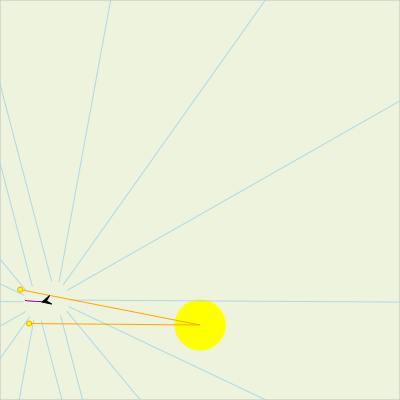

29 0 [ 0.5  0.5] [ 0.5  0.5]
29 1 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 2 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 3 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 4 [ 0.07246636  0.52682716] [ 0.07246636  0.52682716]
29 5 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 6 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 7 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 8 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 9 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
29 10 [ 0.77038251  0.93194393] [ 0.77038251  0.93194393]
29 11 [ 0.5520867   0.16769625] [ 0.5520867   0.16769625]
Goal 29


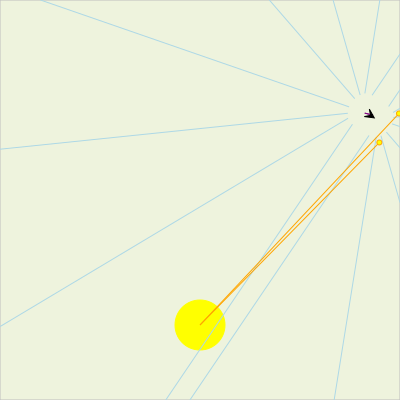

33 0 [ 0.5  0.5] [ 0.5  0.5]
33 1 [ 0.11409606  0.31777896] [ 0.11409606  0.31777896]
33 2 [ 0.11409606  0.31777896] [ 0.11409606  0.31777896]
33 3 [ 0.11409606  0.31777896] [ 0.11409606  0.31777896]
33 4 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 5 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 6 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 7 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 8 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 9 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
33 10 [ 0.03022118  0.03876438] [ 0.03022118  0.03876438]
33 11 [ 0.44436408  0.89046775] [ 0.44436408  0.89046775]
Goal 33


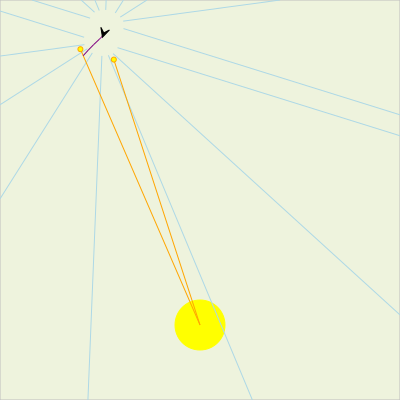

39 0 [ 0.5  0.5] [ 0.5  0.5]
39 1 [ 0.62316554  0.78899734] [ 0.62316554  0.78899734]
39 2 [ 0.62316554  0.78899734] [ 0.62316554  0.78899734]
39 3 [ 0.62316554  0.78899734] [ 0.62316554  0.78899734]
39 4 [ 0.62316554  0.78899734] [ 0.62316554  0.78899734]
39 5 [ 0.62316554  0.78899734] [ 0.62316554  0.78899734]
39 6 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
39 7 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
39 8 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
39 9 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
39 10 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
39 11 [ 0.84265506  0.99937114] [ 0.84265506  0.99937114]
Goal 39


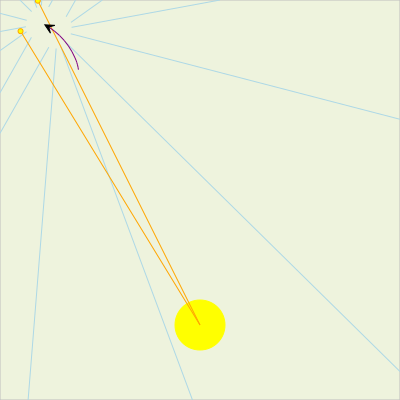

40 0 [ 0.5  0.5] [ 0.5  0.5]
40 1 [ 0.65073144  0.38975265] [ 0.65073144  0.38975265]
40 2 [ 0.65073144  0.38975265] [ 0.65073144  0.38975265]
40 3 [ 0.65073144  0.38975265] [ 0.65073144  0.38975265]
40 4 [ 0.65073144  0.38975265] [ 0.65073144  0.38975265]
40 5 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 6 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 7 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 8 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 9 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 10 [ 0.33272589  0.90482181] [ 0.33272589  0.90482181]
40 11 [ 0.17789765  0.86387146] [ 0.17789765  0.86387146]
Goal 40


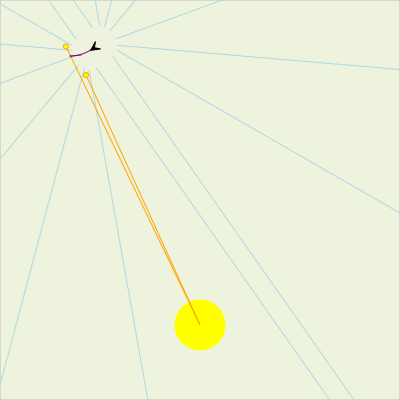

59 0 [ 0.5  0.5] [ 0.5  0.5]
59 1 [ 0.09984668  0.17584192] [ 0.09984668  0.17584192]
59 2 [ 0.09984668  0.17584192] [ 0.09984668  0.17584192]
59 3 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 4 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 5 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 6 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 7 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 8 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 9 [ 0.54958553  0.33401549] [ 0.54958553  0.33401549]
59 10 [ 0.09667999  0.52738884] [ 0.09667999  0.52738884]
59 11 [ 0.54958553  0.33401549] [ 0.54958553  0.33401549]
Goal 59


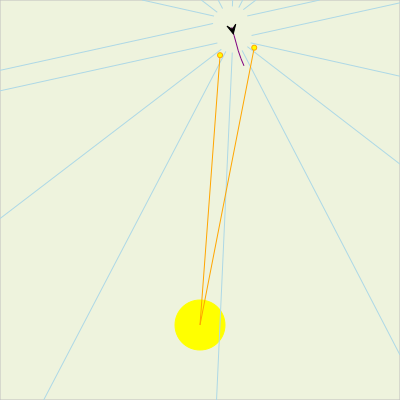

68 0 [ 0.5  0.5] [ 0.5  0.5]
68 1 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 2 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 3 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 4 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 5 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 6 [ 0.97905087  0.23206347] [ 0.97905087  0.23206347]
68 7 [ 0.98767049  0.73186211] [ 0.98767049  0.73186211]
68 8 [ 0.98767049  0.73186211] [ 0.98767049  0.73186211]
68 9 [ 0.98767049  0.73186211] [ 0.98767049  0.73186211]
68 10 [ 0.98767049  0.73186211] [ 0.98767049  0.73186211]
68 11 [ 0.98767049  0.73186211] [ 0.98767049  0.73186211]
Goal 68


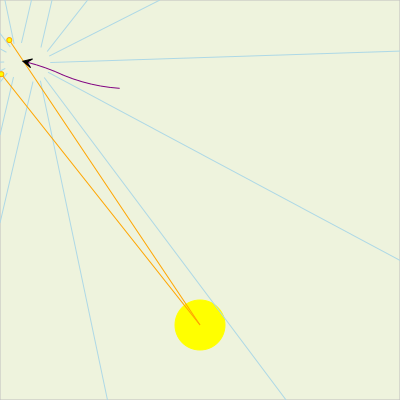

In [25]:
# Verify that we will learn the correct things:
myseq = 0
for seq in goalset: 
    canvas = Canvas((400, 400))
    gd.robot.useTrail = True
    gd.robot.display["trail"] = 1
    gd.robot.display["body"] = 0
    gd.robot.trail[:] = []
    # put robot at initial pose:
    pose = log["poses"][log["goals"][seq] - gd.recall_steps]
    gd.robot.setPose(*pose)
    gd.robot.stall = log["stalls"][log["goals"][seq] - gd.recall_steps]
    for i in range(len(sequence_dataset[myseq * 12:myseq * 12 + 12])):
        h1 = sequence_dataset[myseq * 12 + i][0][:hidden_size]
        print(seq, i, stepwise_dict[tuple(h1)][-2:], stepwise_dataset[myseq * 13 + i][1][-2:])
        motor_output = (stepwise_dataset[myseq * 13 + i][1][-2:] * 2.0) - 1.0
        if i == 0:
            # don't really move, that should be no-op
            pass
        else:
            gd.robot.move(*motor_output)
            gd.sim.step()
    myseq += 1
    print("Goal", seq)
    gd.sim.draw(canvas)
    display(canvas)


10 0 [ 0.50514855  0.49367791] [ 0.5  0.5]
10 1 [ 0.78141106  0.6912885 ] [ 0.77100438  0.68047352]
10 2 [ 0.78141106  0.6912885 ] [ 0.77100438  0.68047352]
10 3 [ 0.35000539  0.60093687] [ 0.38208515  0.5904439 ]
10 4 [ 0.38709274  0.60483274] [ 0.38208515  0.5904439 ]
10 5 [ 0.3832159   0.60136495] [ 0.38208515  0.5904439 ]
10 6 [ 0.3792025  0.5975933] [ 0.38208515  0.5904439 ]
10 7 [ 0.37520191  0.59354395] [ 0.38208515  0.5904439 ]
10 8 [ 0.37138997  0.58927461] [ 0.38208515  0.5904439 ]
10 9 [ 0.36523289  0.90259172] [ 0.37585798  0.94142052]
10 10 [ 0.37826808  0.90358148] [ 0.37585798  0.94142052]
10 11 [ 0.36944456  0.91620357] [ 0.37585798  0.94142052]
Goal 10


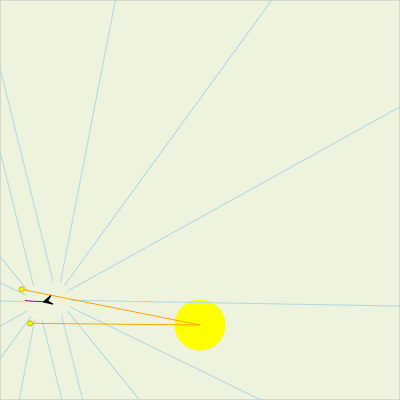

29 0 [ 0.52113826  0.48990446] [ 0.5  0.5]
29 1 [ 0.55694068  0.1662037 ] [ 0.5520867   0.16769625]
29 2 [ 0.55694068  0.1662037 ] [ 0.5520867   0.16769625]
29 3 [ 0.55694068  0.1662037 ] [ 0.5520867   0.16769625]
29 4 [ 0.09220199  0.52857555] [ 0.07246636  0.52682716]
29 5 [ 0.56054911  0.16040626] [ 0.5520867   0.16769625]
29 6 [ 0.56410512  0.16199533] [ 0.5520867   0.16769625]
29 7 [ 0.55733396  0.16523912] [ 0.5520867   0.16769625]
29 8 [ 0.54606255  0.17018079] [ 0.5520867   0.16769625]
29 9 [ 0.53576037  0.17480491] [ 0.5520867   0.16769625]
29 10 [ 0.76853921  0.90606371] [ 0.77038251  0.93194393]
29 11 [ 0.55726497  0.1764273 ] [ 0.5520867   0.16769625]
Goal 29


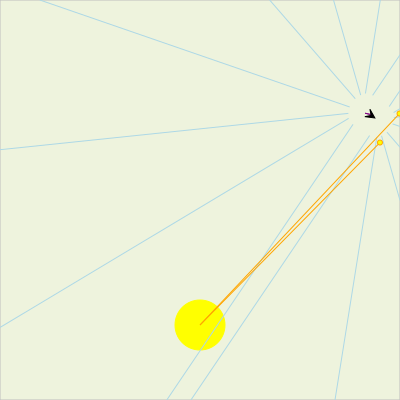

33 0 [ 0.49708154  0.50564586] [ 0.5  0.5]
33 1 [ 0.1079223  0.3070321] [ 0.11409606  0.31777896]
33 2 [ 0.11007976  0.31675962] [ 0.11409606  0.31777896]
33 3 [ 0.11213918  0.32743047] [ 0.11409606  0.31777896]
33 4 [ 0.4433615   0.89823594] [ 0.44436408  0.89046775]
33 5 [ 0.45486366  0.89334193] [ 0.44436408  0.89046775]
33 6 [ 0.45231181  0.89141011] [ 0.44436408  0.89046775]
33 7 [ 0.4509478   0.89150673] [ 0.44436408  0.89046775]
33 8 [ 0.4519544   0.89276069] [ 0.44436408  0.89046775]
33 9 [ 0.44380654  0.88926241] [ 0.44436408  0.89046775]
33 10 [ 0.03733281  0.0475217 ] [ 0.03022118  0.03876438]
33 11 [ 0.43276484  0.8972269 ] [ 0.44436408  0.89046775]
Goal 33


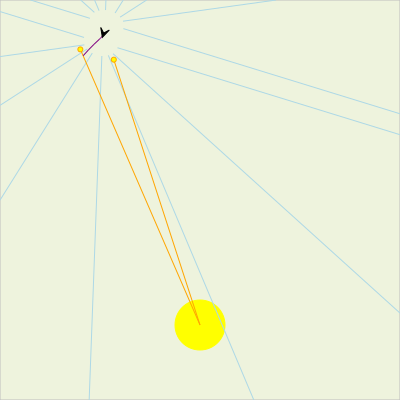

39 0 [ 0.51511544  0.47657011] [ 0.5  0.5]
39 1 [ 0.63174693  0.79811091] [ 0.62316554  0.78899734]
39 2 [ 0.62950124  0.80301673] [ 0.62316554  0.78899734]
39 3 [ 0.6289585   0.81608038] [ 0.62316554  0.78899734]
39 4 [ 0.62904379  0.82720549] [ 0.62316554  0.78899734]
39 5 [ 0.62834675  0.83410089] [ 0.62316554  0.78899734]
39 6 [ 0.81944022  0.95467551] [ 0.84265506  0.99937114]
39 7 [ 0.83332672  0.95904696] [ 0.84265506  0.99937114]
39 8 [ 0.8607519   0.96677522] [ 0.84265506  0.99937114]
39 9 [ 0.8747506   0.97074343] [ 0.84265506  0.99937114]
39 10 [ 0.86917888  0.97046863] [ 0.84265506  0.99937114]
39 11 [ 0.84462649  0.96536923] [ 0.84265506  0.99937114]
Goal 39


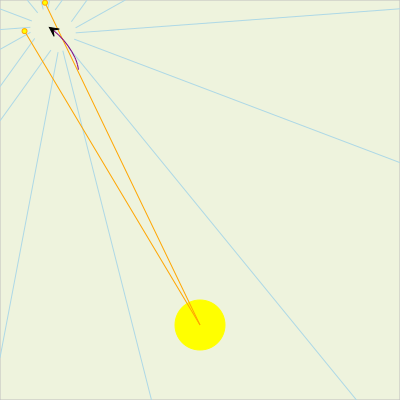

40 0 [ 0.46131919  0.51529184] [ 0.5  0.5]
40 1 [ 0.663003   0.3878112] [ 0.65073144  0.38975265]
40 2 [ 0.66691539  0.3886133 ] [ 0.65073144  0.38975265]
40 3 [ 0.66995354  0.39003442] [ 0.65073144  0.38975265]
40 4 [ 0.67221996  0.39196927] [ 0.65073144  0.38975265]
40 5 [ 0.34014695  0.90673623] [ 0.33272589  0.90482181]
40 6 [ 0.33978003  0.9087252 ] [ 0.33272589  0.90482181]
40 7 [ 0.33165124  0.90868475] [ 0.33272589  0.90482181]
40 8 [ 0.32956856  0.90532858] [ 0.33272589  0.90482181]
40 9 [ 0.33752986  0.90658656] [ 0.33272589  0.90482181]
40 10 [ 0.3309836   0.90217836] [ 0.33272589  0.90482181]
40 11 [ 0.17919229  0.8783963 ] [ 0.17789765  0.86387146]
Goal 40


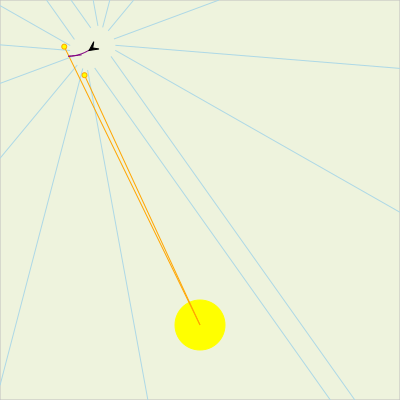

59 0 [ 0.50487887  0.52361325] [ 0.5  0.5]
59 1 [ 0.1127209   0.18706607] [ 0.09984668  0.17584192]
59 2 [ 0.10431978  0.17459846] [ 0.09984668  0.17584192]
59 3 [ 0.10551234  0.5143153 ] [ 0.09667999  0.52738884]
59 4 [ 0.10007713  0.52115601] [ 0.09667999  0.52738884]
59 5 [ 0.09501486  0.52784704] [ 0.09667999  0.52738884]
59 6 [ 0.09290047  0.54657581] [ 0.09667999  0.52738884]
59 7 [ 0.09831139  0.53430845] [ 0.09667999  0.52738884]
59 8 [ 0.09831139  0.53430845] [ 0.09667999  0.52738884]
59 9 [ 0.55013824  0.32983927] [ 0.54958553  0.33401549]
59 10 [ 0.09189954  0.53062831] [ 0.09667999  0.52738884]
59 11 [ 0.55117854  0.32277847] [ 0.54958553  0.33401549]
Goal 59


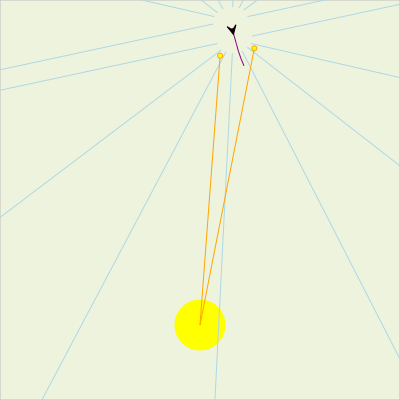

68 0 [ 0.53170079  0.4843303 ] [ 0.5  0.5]
68 1 [ 0.94654627  0.23177372] [ 0.97905087  0.23206347]
68 2 [ 0.94615781  0.24362042] [ 0.97905087  0.23206347]
68 3 [ 0.94803618  0.24621549] [ 0.97905087  0.23206347]
68 4 [ 0.94889361  0.2501158 ] [ 0.97905087  0.23206347]
68 5 [ 0.96102586  0.22398269] [ 0.97905087  0.23206347]
68 6 [ 0.96880601  0.20677823] [ 0.97905087  0.23206347]
68 7 [ 0.95438186  0.73420267] [ 0.98767049  0.73186211]
68 8 [ 0.95828288  0.73445871] [ 0.98767049  0.73186211]
68 9 [ 0.96035613  0.7365315 ] [ 0.98767049  0.73186211]
68 10 [ 0.96157417  0.73594438] [ 0.98767049  0.73186211]
68 11 [ 0.96152427  0.7387675 ] [ 0.98767049  0.73186211]
Goal 68


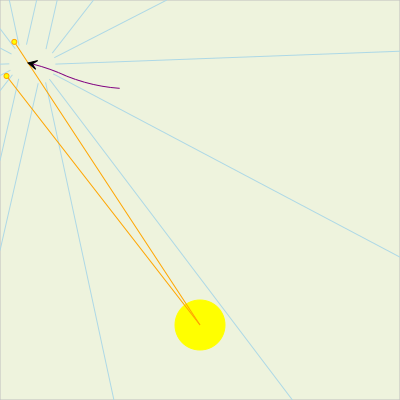

In [26]:
# Verify that hidden to motors:
myseq = 0
for seq in goalset: 
    canvas = Canvas((400, 400))
    gd.robot.useTrail = True
    gd.robot.display["trail"] = 1
    gd.robot.display["body"] = 0
    gd.robot.trail[:] = []
    # put robot at initial pose:
    pose = log["poses"][log["goals"][seq] - gd.recall_steps]
    gd.robot.setPose(*pose)
    gd.robot.stall = log["stalls"][log["goals"][seq] - gd.recall_steps]
    for i in range(len(sequence_dataset[myseq * 12:myseq * 12 + 12])):
        h1 = sequence_dataset[myseq * 12 + i][0][:hidden_size]
        motor_output = stepwise.layer[1].propagate(h1)[-2:]
        print(seq, i, motor_output, stepwise_dataset[myseq * 13 + i][1][-2:])
        motor_output = (motor_output * 2.0) - 1.0
        if i == 0:
            # don't really move, that should be no-op
            pass
        else:
            gd.robot.move(*motor_output)
            gd.sim.step()
    myseq += 1
    print("Goal", seq)
    gd.sim.draw(canvas)
    display(canvas)


10 0 [ 0.5  0.5] [ 0.5  0.5]
10 1 [ 0.77100438  0.68047352] [ 0.43263627  0.39075653]
10 2 [ 0.77100438  0.68047352] [ 0.48950171  0.47247633]
10 3 [ 0.38208515  0.5904439 ] [ 0.44370068  0.39940578]
10 4 [ 0.38208515  0.5904439 ] [ 0.48580932  0.47296753]
10 5 [ 0.38208515  0.5904439 ] [ 0.44092113  0.40892141]
10 6 [ 0.38208515  0.5904439 ] [ 0.48011355  0.49268121]
10 7 [ 0.38208515  0.5904439 ] [ 0.43203931  0.41987736]
10 8 [ 0.38208515  0.5904439 ] [ 0.47447499  0.52845314]
10 9 [ 0.37585798  0.94142052] [ 0.42095596  0.43155753]
10 10 [ 0.37585798  0.94142052] [ 0.46895081  0.57487777]
10 11 [ 0.37585798  0.94142052] [ 0.40989065  0.44832346]
Goal 10


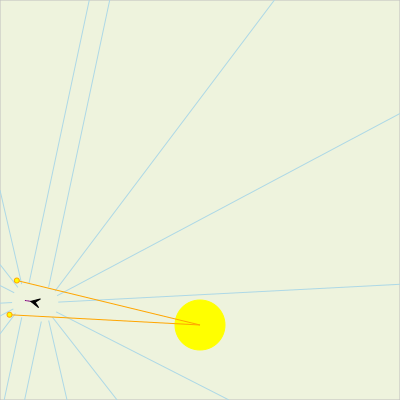

29 0 [ 0.5  0.5] [ 0.5  0.5]
29 1 [ 0.5520867   0.16769625] [ 0.5530118  0.0614729]
29 2 [ 0.5520867   0.16769625] [ 0.3315834   0.25308283]
29 3 [ 0.5520867   0.16769625] [ 0.60027027  0.11801857]
29 4 [ 0.07246636  0.52682716] [ 0.57645954  0.22833883]
29 5 [ 0.5520867   0.16769625] [ 0.59479674  0.50243636]
29 6 [ 0.5520867   0.16769625] [ 0.65831362  0.28047559]
29 7 [ 0.5520867   0.16769625] [ 0.57223903  0.41642666]
29 8 [ 0.5520867   0.16769625] [ 0.64708505  0.34953957]
29 9 [ 0.5520867   0.16769625] [ 0.60269908  0.3816052 ]
29 10 [ 0.77038251  0.93194393] [ 0.63025498  0.37430477]
29 11 [ 0.5520867   0.16769625] [ 0.61847499  0.3720055 ]
Goal 29


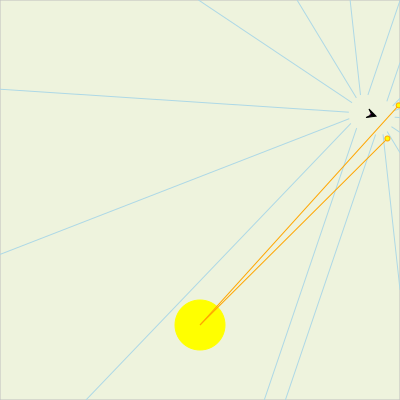

33 0 [ 0.5  0.5] [ 0.5  0.5]
33 1 [ 0.11409606  0.31777896] [ 0.09036854  0.24249812]
33 2 [ 0.11409606  0.31777896] [ 0.2289167   0.56000264]
33 3 [ 0.11409606  0.31777896] [ 0.24586371  0.72464297]
33 4 [ 0.44436408  0.89046775] [ 0.51102427  0.90918806]
33 5 [ 0.44436408  0.89046775] [ 0.48217033  0.90506593]
33 6 [ 0.44436408  0.89046775] [ 0.38024406  0.82928151]
33 7 [ 0.44436408  0.89046775] [ 0.16066051  0.38338057]
33 8 [ 0.44436408  0.89046775] [ 0.35189424  0.72520132]
33 9 [ 0.44436408  0.89046775] [ 0.0368907   0.03236946]
33 10 [ 0.03022118  0.03876438] [ 0.43304766  0.82766613]
33 11 [ 0.44436408  0.89046775] [ 0.02551694  0.01928157]
Goal 33


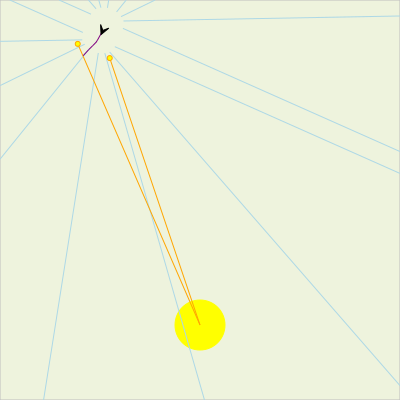

39 0 [ 0.5  0.5] [ 0.5  0.5]
39 1 [ 0.62316554  0.78899734] [ 0.64994372  0.78453971]
39 2 [ 0.62316554  0.78899734] [ 0.63548799  0.77422175]
39 3 [ 0.62316554  0.78899734] [ 0.66541313  0.82881848]
39 4 [ 0.62316554  0.78899734] [ 0.73460961  0.88662166]
39 5 [ 0.62316554  0.78899734] [ 0.80859806  0.93553921]
39 6 [ 0.84265506  0.99937114] [ 0.85706495  0.96142475]
39 7 [ 0.84265506  0.99937114] [ 0.88329131  0.9672271 ]
39 8 [ 0.84265506  0.99937114] [ 0.91758241  0.96982101]
39 9 [ 0.84265506  0.99937114] [ 0.91969735  0.95407739]
39 10 [ 0.84265506  0.99937114] [ 0.73323591  0.91966017]
39 11 [ 0.84265506  0.99937114] [ 0.60240481  0.86496287]
Goal 39


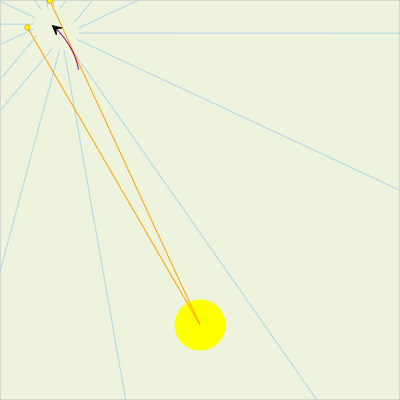

40 0 [ 0.5  0.5] [ 0.5  0.5]
40 1 [ 0.65073144  0.38975265] [ 0.64084704  0.3639509 ]
40 2 [ 0.65073144  0.38975265] [ 0.60452978  0.42331806]
40 3 [ 0.65073144  0.38975265] [ 0.59884098  0.49278761]
40 4 [ 0.65073144  0.38975265] [ 0.57881279  0.53647456]
40 5 [ 0.33272589  0.90482181] [ 0.56312544  0.55706791]
40 6 [ 0.33272589  0.90482181] [ 0.5557052   0.55634338]
40 7 [ 0.33272589  0.90482181] [ 0.55827716  0.53955622]
40 8 [ 0.33272589  0.90482181] [ 0.56539966  0.51853396]
40 9 [ 0.33272589  0.90482181] [ 0.56873021  0.50921751]
40 10 [ 0.33272589  0.90482181] [ 0.5648435   0.51613457]
40 11 [ 0.17789765  0.86387146] [ 0.55702427  0.52780281]
Goal 40


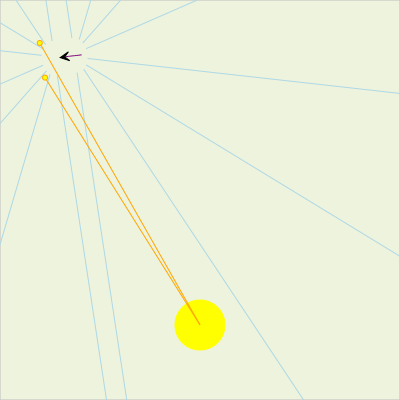

59 0 [ 0.5  0.5] [ 0.5  0.5]
59 1 [ 0.09984668  0.17584192] [ 0.10153025  0.16784086]
59 2 [ 0.09984668  0.17584192] [ 0.10510835  0.37757361]
59 3 [ 0.09667999  0.52738884] [ 0.09348664  0.47641467]
59 4 [ 0.09667999  0.52738884] [ 0.08984875  0.53255041]
59 5 [ 0.09667999  0.52738884] [ 0.07981415  0.47612551]
59 6 [ 0.09667999  0.52738884] [ 0.21881896  0.49408491]
59 7 [ 0.09667999  0.52738884] [ 0.09652712  0.29261839]
59 8 [ 0.09667999  0.52738884] [ 0.37467172  0.86673385]
59 9 [ 0.54958553  0.33401549] [ 0.05718671  0.06558462]
59 10 [ 0.09667999  0.52738884] [ 0.52422788  0.97474674]
59 11 [ 0.54958553  0.33401549] [ 0.06556723  0.10001993]
Goal 59


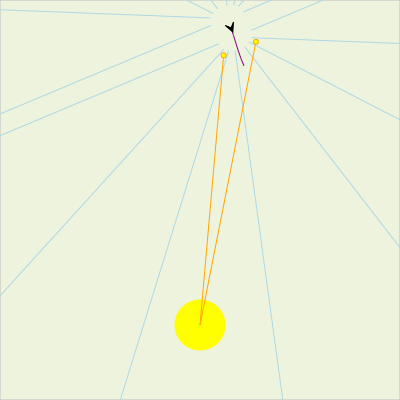

68 0 [ 0.5  0.5] [ 0.5  0.5]
68 1 [ 0.97905087  0.23206347] [ 0.94401766  0.20901829]
68 2 [ 0.97905087  0.23206347] [ 0.95009137  0.21924251]
68 3 [ 0.97905087  0.23206347] [ 0.95271116  0.20981955]
68 4 [ 0.97905087  0.23206347] [ 0.95693265  0.20231008]
68 5 [ 0.97905087  0.23206347] [ 0.96404104  0.27446809]
68 6 [ 0.97905087  0.23206347] [ 0.96022839  0.5059952 ]
68 7 [ 0.98767049  0.73186211] [ 0.96266798  0.61932217]
68 8 [ 0.98767049  0.73186211] [ 0.95863015  0.6981384 ]
68 9 [ 0.98767049  0.73186211] [ 0.95525979  0.70938505]
68 10 [ 0.98767049  0.73186211] [ 0.95593213  0.67608783]
68 11 [ 0.98767049  0.73186211] [ 0.95978677  0.73193635]
Goal 68


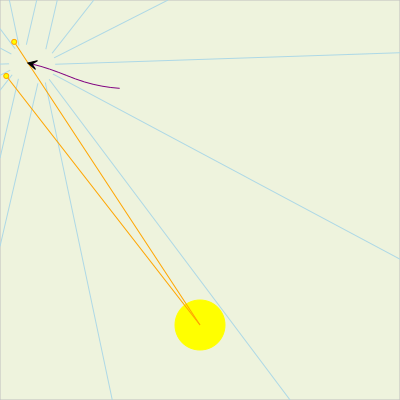

In [27]:
# Test learning:
myseq = 0
for seq in goalset:
    canvas = Canvas((400, 400))
    gd.robot.useTrail = True
    gd.robot.display["trail"] = 1
    gd.robot.display["body"] = 0
    gd.robot.trail[:] = []
    hidden_goal = sequence_dataset[myseq * 12][0][hidden_size:]
    # put robot at initial pose:
    pose = log["poses"][log["goals"][seq] - gd.recall_steps]
    gd.robot.setPose(*pose)
    gd.robot.stall = log["stalls"][log["goals"][seq] - gd.recall_steps]
    # get sensors:
    sensor_t0 = gd.read_sensors()[0]
    # get hidden_t0:
    motor_t0 = np.array([0, 0])
    hidden = stepwise.layer[0].propagate(np.concatenate([sensor_t0, (motor_t0 + 1.0)/2.0]))
    h1 = sequence.propagate(np.concatenate([hidden, hidden_goal]))
    if list(hidden_goal) != list(sequence_dataset[myseq * 12][0][hidden_size:]):
        print("hidden_goal is wrong wrong!")
        break        
    if list(hidden) != list(sequence_dataset[myseq * 12][0][:hidden_size]):
        print("initial hidden wrong!")
        break
    for i in range(len(sequence_dataset[myseq * 12:myseq * 12 + 12])):
        motor_output = stepwise.layer[1].propagate(h1)[-2:]
        if i == 0:
            # don't really move, that should be no-op
            motor_output = np.array([0.5, 0.5])
        print(seq, i, stepwise_dataset[myseq * 13 + i][0][-2:], motor_output)
        motor_output = motor_output * 2.0 - 1.0
        gd.robot.move(*motor_output)
        gd.sim.step()
        sensor_t0 = gd.read_sensors()[0]
        hidden = stepwise.layer[0].propagate(np.concatenate([sensor_t0, (motor_output + 1.0)/2.0]))
        h1 = sequence.propagate(np.concatenate([hidden, hidden_goal]))
    myseq += 1
    print("Goal", seq)
    gd.sim.draw(canvas)
    display(canvas)
        